# Neural Network on All Features

Import all necessary libraries, set matplotlib settings

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import sklearn.metrics
from scipy import stats
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_curve, recall_score, accuracy_score, precision_score, confusion_matrix
import gzip
import matplotlib.pyplot as plt
import matplotlib
plt.style.use("ggplot")
%matplotlib inline

In [2]:
matplotlib.rcParams['figure.dpi'] = 200

Set a random state to ensure replicability. Also, set cutoffs for our CNVs, since very small and very large CNVs are almost always benign and pathogenic respectively.


In [3]:
rand_state = 233
lower_bound = 2000
upper_bound = 5000000

Initialize our data files/filenames for training

In [4]:
file = gzip.open('./data/output_features_07_26_no_genelists.csv.gz')
df = pd.read_csv(file, dtype=str)

Drop columns that shouldn't be features, such as the genes, or chromsome number. This also includes repetitive elements that were classified as "Other" or "Unknown". Finally convert every value to a float.

In [5]:
df.drop(['genes_in_proximity','chr', 'start', 'end', 'Unnamed: 0', 'drop'], axis=1, inplace=True)
df.drop(['repeat_Other', 'repeat_Unknown'], axis=1, inplace=True)
df = df.astype(float)

Since the values have been converted from a string to a float, we can do the size cutoffs

In [6]:
# cutoffs
df = df[df["size"] > lower_bound]
df = df[df["size"] < upper_bound]

It seems scikit learn tends to like binary classification outputs of {0, 1}, not {-1, 1}. Also we need to seperate out the pathogenicity values, a.k.a. the values we want the classifier to output

In [7]:
df['pathogenicity'] = df['pathogenicity'].replace(-1, 0)
x_labels = df['pathogenicity'].values
df.drop(['pathogenicity'], axis=1, inplace=True)

We need to create the gene and repetitive element density values

In [8]:
df['gene_density'] = df['number_of_genes_in_proximity'] / df['size'] * 100000
cols = [c for c in df.columns if c.lower()[:6] == 'repeat']
for col in cols:
    df[col + '_density'] = df[col] / df['size'] * 100000

My gene_list feature was not as good a feature as I originally thought it would be, so I drop any gene_list feature columns here

In [9]:
cols = [c for c in df.columns if c.lower()[:4] == 'bioc' or c.lower()[:4] == 'kegg' or c.lower()[:5] == 'react']
df = df.drop(cols,axis=1)
to_be_scaled = df.columns

Finally, since here we are training the model on selected features, we construct a list of those features. If training on all features, simply uncomment the line underneath. Then we set the dataframe to only include those features

In [10]:
to_be_scaled = ['repeat_LTR_density','repeat_SINE_density','repeat_LINE_density','repeat_Low complexity_density','repeat_Transposable element_density',
'repeat_Simple repeat_density','repeat_LINE','repeat_Segmental duplication_density','size','gene_density','mpo_multi_entrez_to_num_phenotypes','mpo_multi_entrez_to_num_phenotypes_using_thresh','mpo_behavior/neurological phenotype',
'mpo_growth/size/body region phenotype','pli_pli_0.0_to_0.1','pli_pli_0.9_to_1.0','pli_pli_0.8_to_0.9',
'pli_pli_0.3_to_0.4','gain_loss','omim_num_diseases', 'number_of_genes_in_proximity']

# to_be_scaled = df.columns

df = df[to_be_scaled]

Define a function for drawing a precision-recall curve using matplotlib

In [11]:
def precision_recall_graph(precisions, recalls):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve")
    plt.step(recalls, precisions, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recalls, precisions, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');


Define a function for finding the precision and threshold for a particular recall rate

In [12]:
def find_threshold_for_recall(precisions, recalls, thresholds, recalls_wanted):
    for recall in recalls_wanted:
        closest_threshold = 0
        for i in range(len(recalls)):
            if recalls[i] - recall < 0:
                closest_threshold = thresholds[i]
                precision_dict[recall].append(precisions[i])
                thresh_dict[recall].append(closest_threshold)
                break
        y_pred_adj = [1 if y >= closest_threshold else 0 for y in y_scores]
        print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))

Since we are running a k-fold cross validation, we end up with multiple different classifiers, feature importance rankings,  scaling constants, etc. Furthermore, we also end up with multiple different accuracy, precision, recall values. We need a way to store all the variables/classifiers for each run of the k-fold cross validation, so we can average them for analysis, and/or also use them when testing on another dataset

In [13]:
# a list of the accuracy for each classifier
accuracy_list = []
# a list of the average precision for each classifier
avg_precision_list = []
# a list of the recalls that are wanted for analysis
recalls_wanted = [0.90, 0.97, 0.99]
# stores a list of the thresholds needed for each classifier for each recall
thresh_dict = {}
for recall in recalls_wanted:
    thresh_dict[recall] = []
# stores a list of precisions for each classifier for each recall
precision_dict = {}
for recall in recalls_wanted:
    precision_dict[recall] = []

# stores each classifier trained per run
clf_list = []
# for box-cox scaling on 'size' feature
lambda_list = []
# for mean 0, std 1 scaling on every feature
scaler_list= []

We need to initialize the k-fold cross validation

In [14]:
kfold = StratifiedKFold(n_splits=5,shuffle=True, random_state=rand_state)
kfold.get_n_splits(df, x_labels)
counter = 0

We set SCALING to true, since Neural Networks need scaling

In [15]:
SCALING = True

The following is the complete training and validation loop

/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


k_Fold 1 Results
     pred_neg  pred_pos
neg      4380       344
pos        79       706
     pred_neg  pred_pos
neg      4148       576
pos        24       761
     pred_neg  pred_pos
neg      3899       825
pos         8       777
k_Fold 2 Results
     pred_neg  pred_pos
neg      4484       240
pos        79       706
     pred_neg  pred_pos
neg      4246       478
pos        24       761
     pred_neg  pred_pos
neg      3932       792
pos         8       777
k_Fold 3 Results
     pred_neg  pred_pos
neg      4389       334
pos        79       705
     pred_neg  pred_pos
neg      4085       638
pos        24       760
     pred_neg  pred_pos
neg      3611      1112
pos         8       776
k_Fold 4 Results
     pred_neg  pred_pos
neg      4450       273
pos        79       705
     pred_neg  pred_pos
neg      4076       647
pos        24       760
     pred_neg  pred_pos
neg      3690      1033
pos         8       776
k_Fold 5 Results
     pred_neg  pred_pos
neg      4410       313
pos

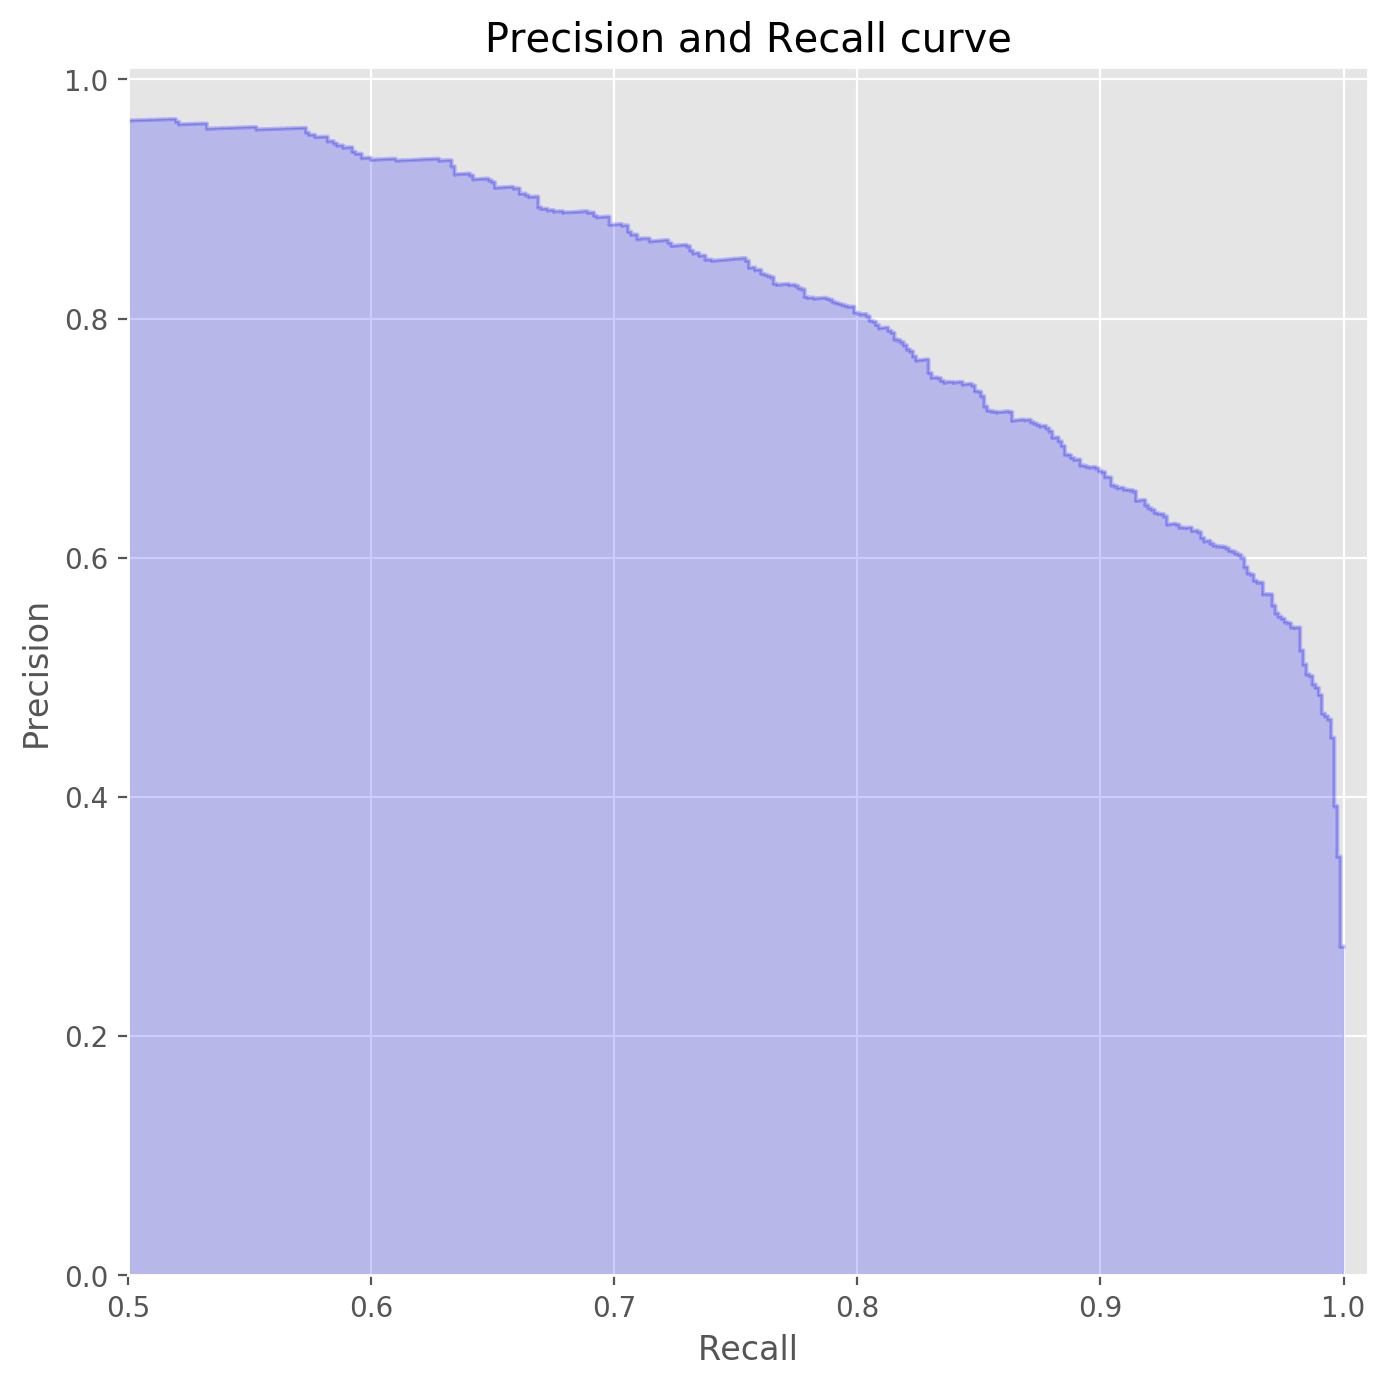

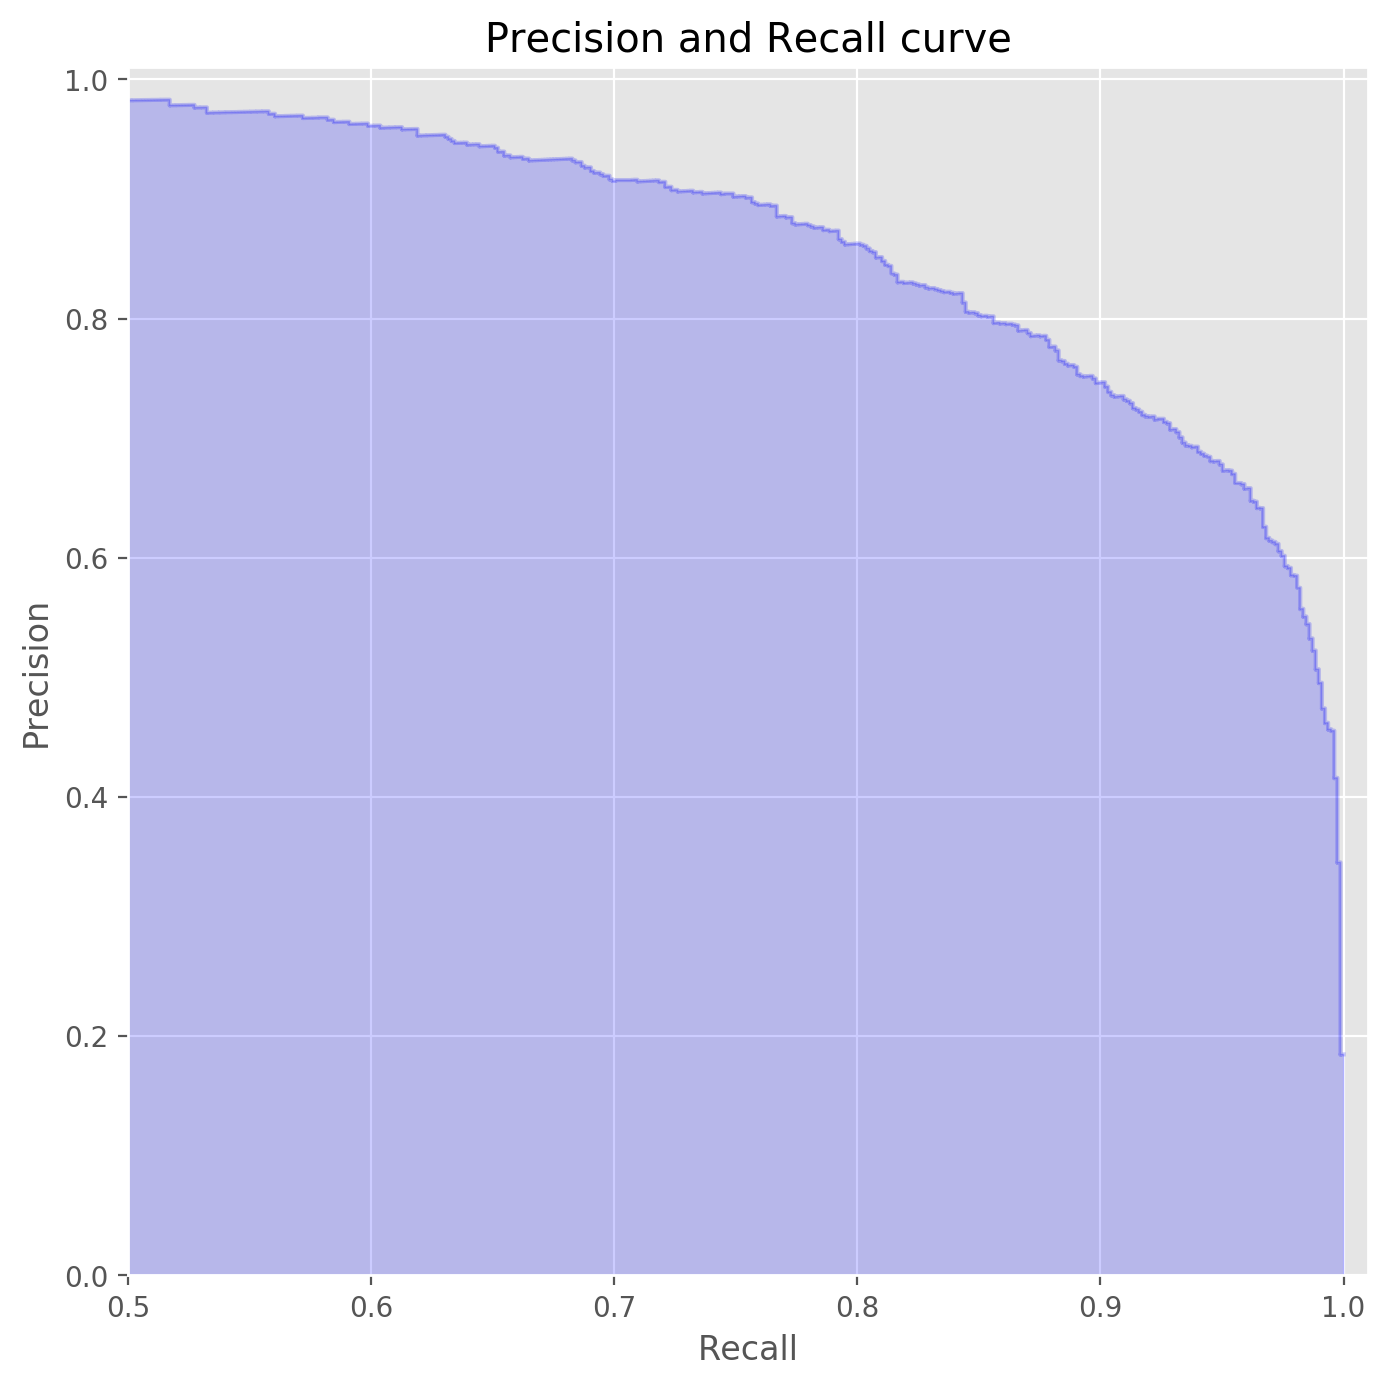

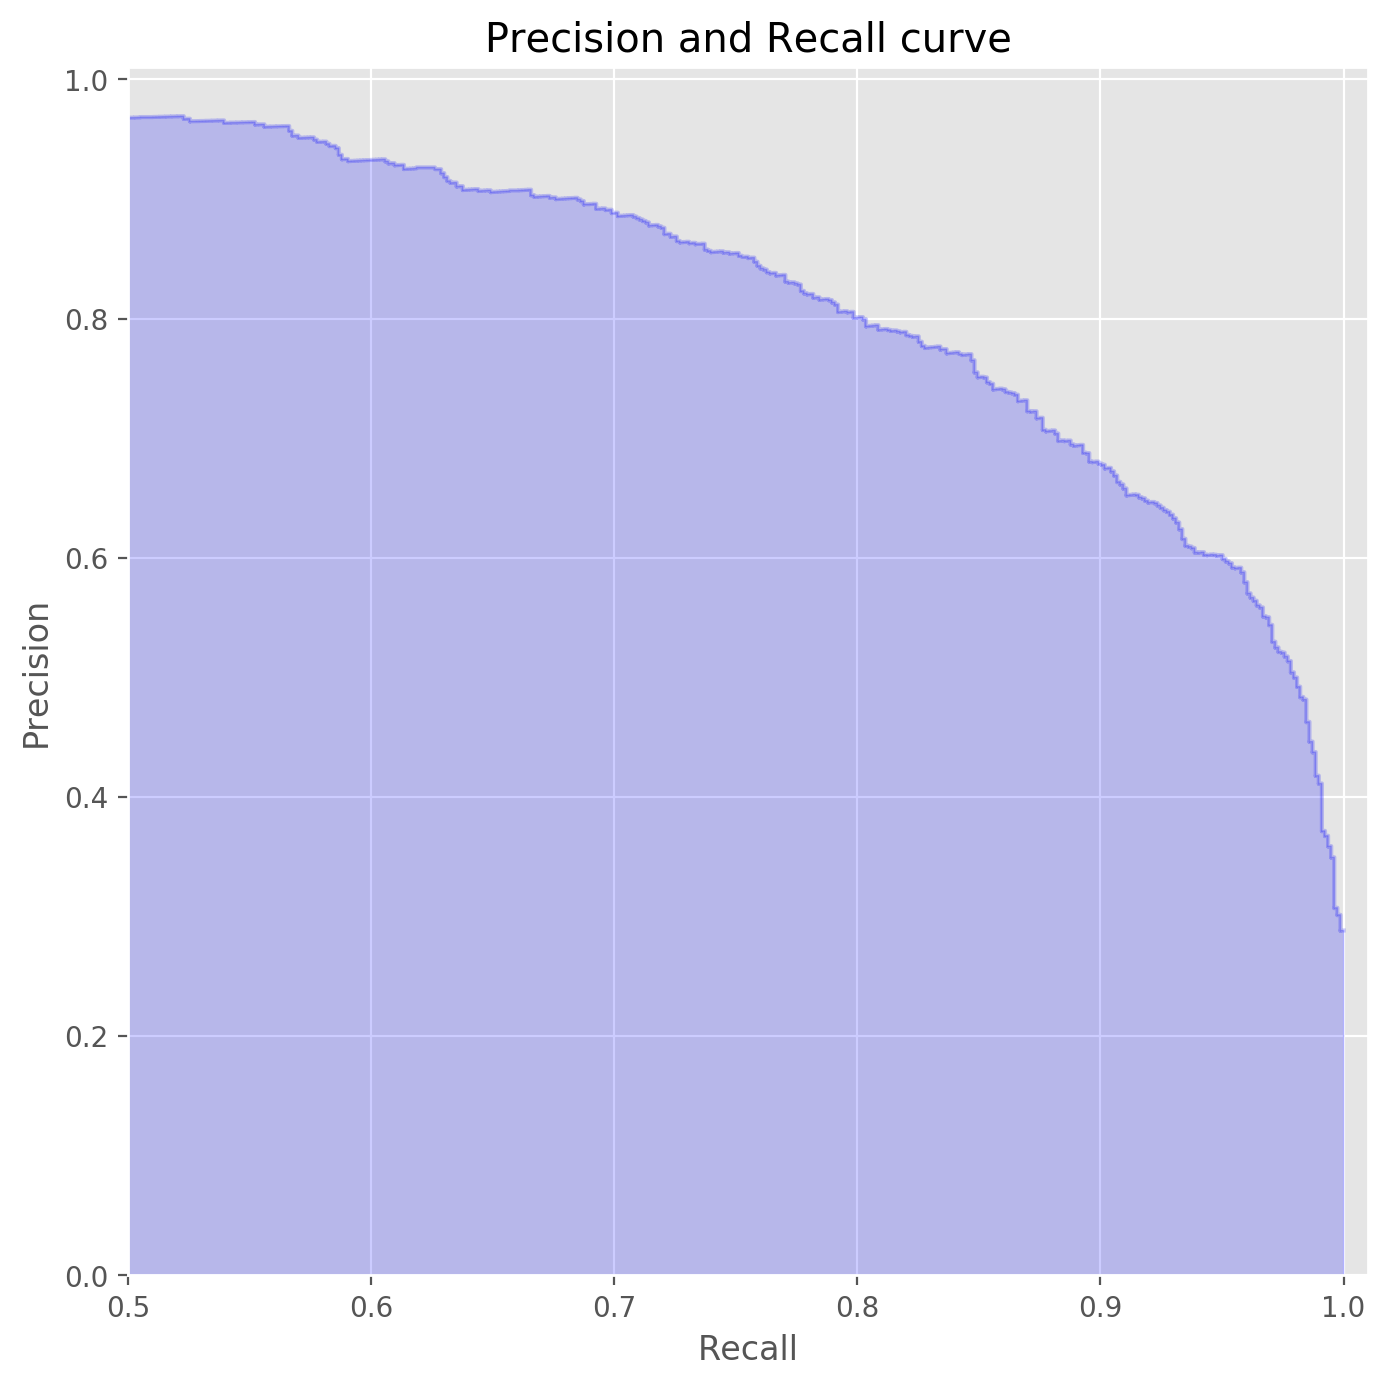

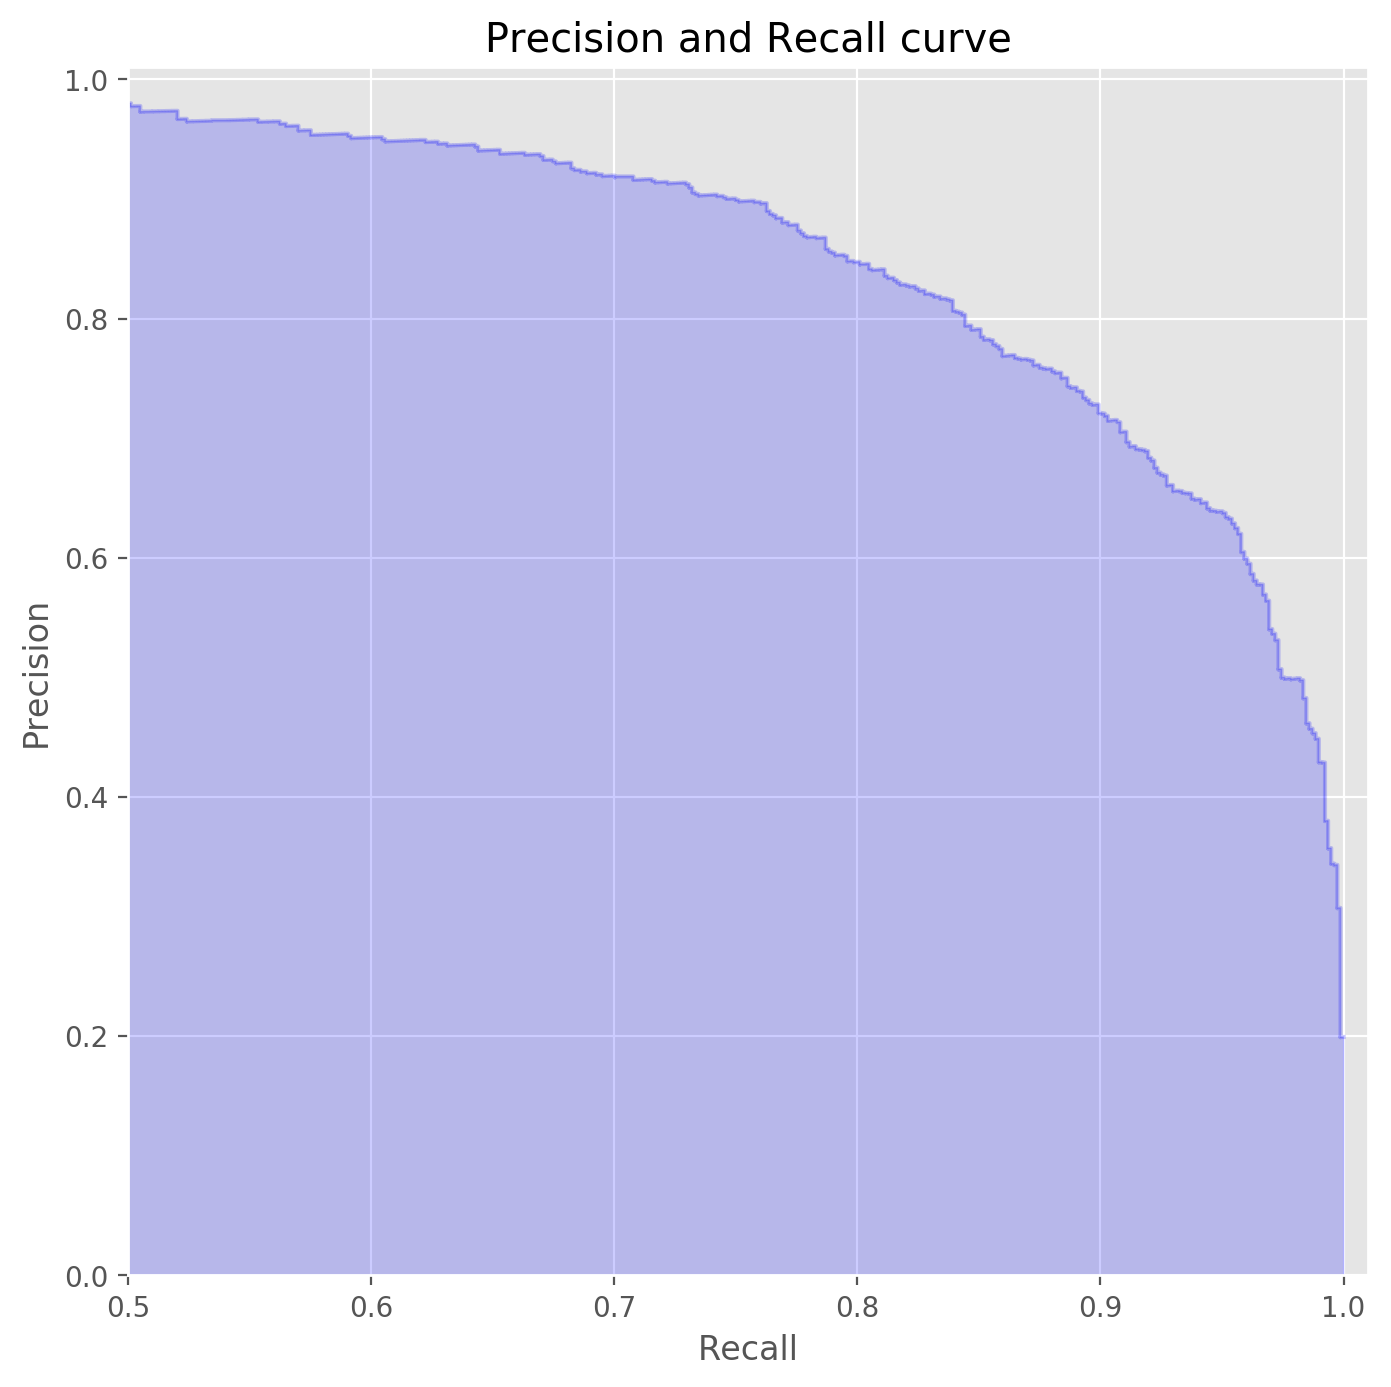

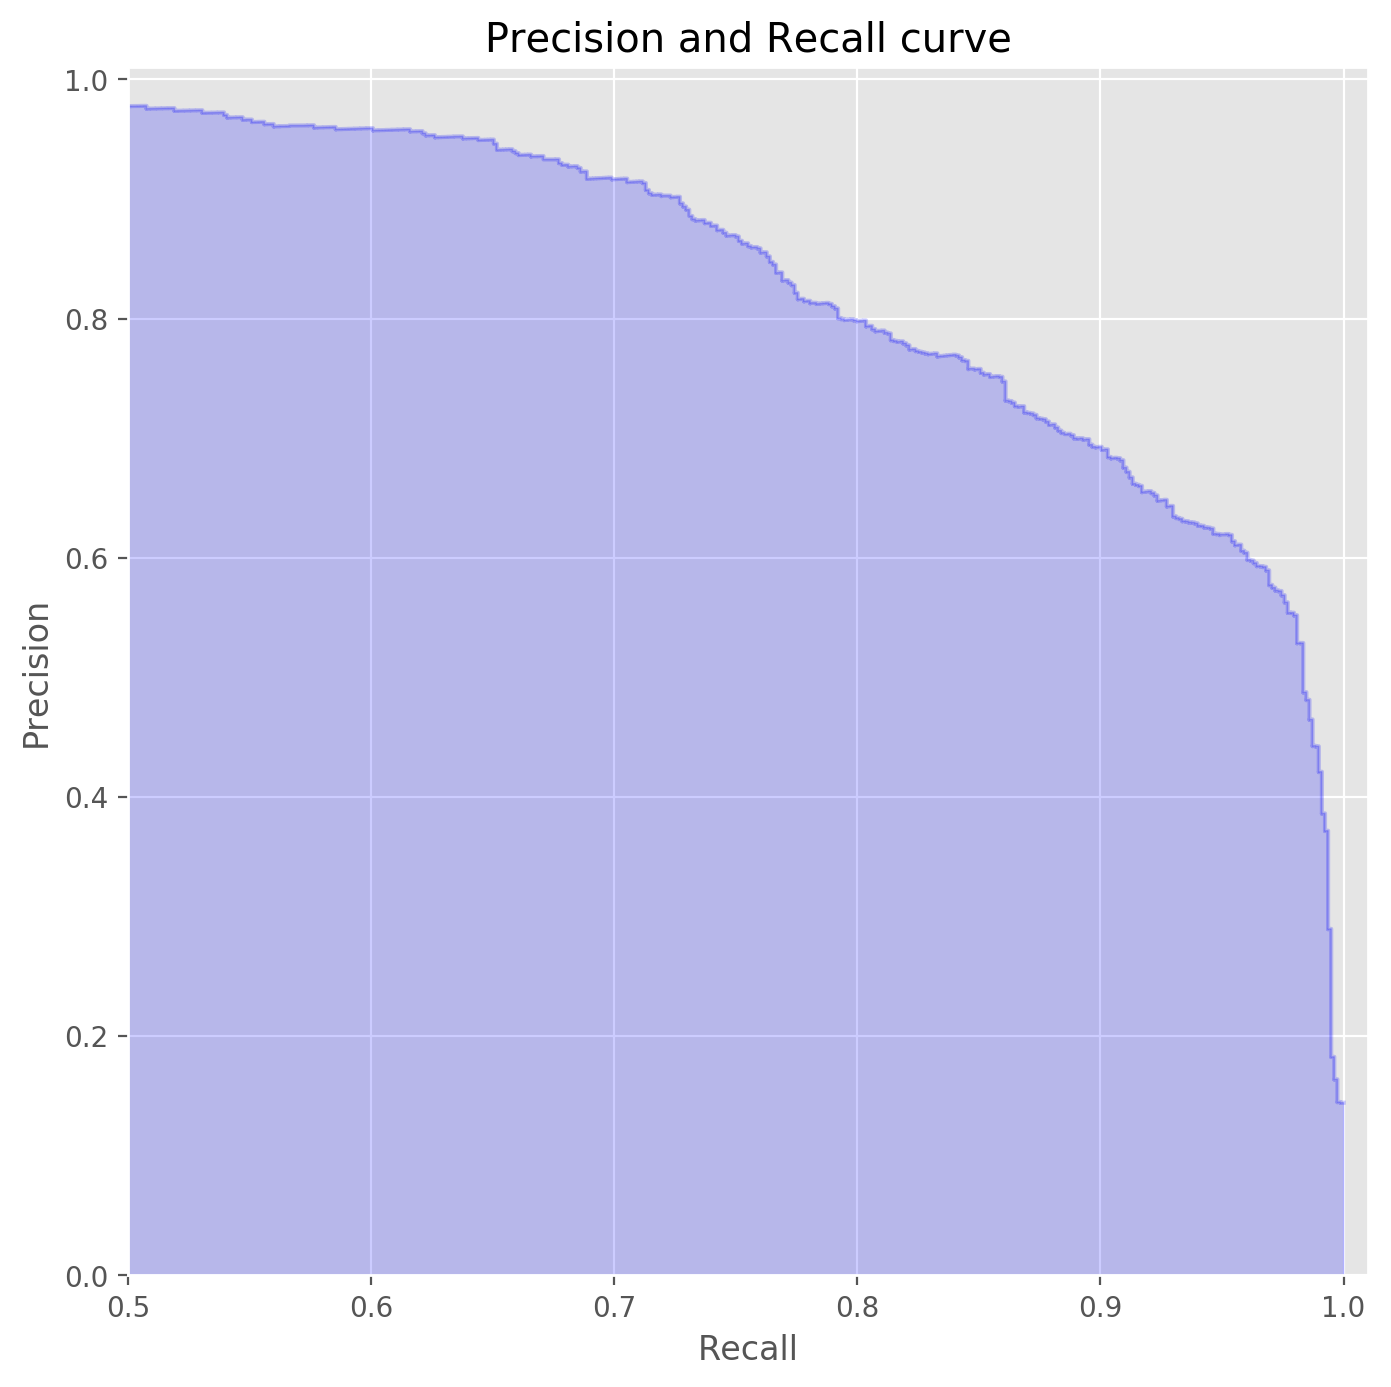

In [16]:
for train_index, test_index in kfold.split(df, x_labels):
    counter += 1
    # use the indices to split the dataframe into the training and validation 
    # segments
    X_pre_train, X_pre_test = df.iloc[train_index], df.iloc[test_index]
    y_train, y_test = x_labels[train_index], x_labels[test_index]
    
    # run the if statement if you would like to scale the features before
    # training. this scaling implements standard mean 0, std 1 scaling, and
    # also boxcox scaling on the 'size' feature
    if SCALING:
        X_pre_train = X_pre_train.copy()
        X_pre_test = X_pre_test.copy()
        # box-cox scaling on training data
        X_pre_train.loc[:,'size'], lmbda = stats.boxcox(\
                                                 X_pre_train['size'].copy())
        lambda_list.append(lmbda)
        # use lambda for box-cox on validation data 
        X_pre_test.loc[:,'size'] = stats.boxcox(\
                                         X_pre_test['size'].copy(), lmbda)
        # standard scaler for all features, including 'size'
        scaler = StandardScaler()
        # save the scaler reference
        scaler_list.append(scaler)
        scaler.fit(X_pre_train)
        # scale both training and validation data
        X_train = scaler.transform(X_pre_train)
        X_test = scaler.transform(X_pre_test)
    else:
        # simply assign variables to the original dataset
        X_train = X_pre_train
        X_test = X_pre_test
    # Neural Network classifier
    clf = MLPClassifier(activation='relu', momentum= .7,
                        solver='adam', max_iter=70, alpha=1e-4,
                        hidden_layer_sizes=(20, 10),
                        random_state=rand_state)
    clf.fit(X_train, y_train)
    
    # make predictions
    preds = clf.predict(X_test)
    # determine accuracy
    accuracy_list.append(accuracy_score(y_test, preds))
    # save classifier
    clf_list.append(clf)
    
    # find probabilities
    y_scores = clf.predict_proba(X_test)[:,1]
    # obtain precision recall matrix
    avg_precision_list.append(sklearn.metrics.average_precision_score(y_test,
                                                                      y_scores))
    p, r, thresholds = precision_recall_curve(y_test, y_scores)
    print("k_Fold " + str(counter) + " Results")
    # save precision for each recall value wanted
    find_threshold_for_recall(p, r, thresholds, recalls_wanted)
    # graph precision recall curve
    precision_recall_graph(p,r)

In [17]:
# show plots if needed
# plt.show()

Print out the precisions for each recall, average precision, and accuracy

In [18]:
for recall in recalls_wanted:
    print("Precision for Recall of ", end='')
    print(str(recall) +':', end='')
    print(" %.4f (±%.4f)" % (np.array(precision_dict[recall]).mean(),
                                np.array(precision_dict[recall]).std()))
print("Average Precision: %.4f (±%.4f)" % (\
                                        np.array(avg_precision_list).mean(),
                                        np.array(avg_precision_list).std()))
print("Accuracy: %.4f (±%.4f)" % (np.array(accuracy_list).mean(),
                                     np.array(accuracy_list).std()))


Precision for Recall of 0.9: 0.7021 (±0.0277)
Precision for Recall of 0.97: 0.5688 (±0.0268)
Precision for Recall of 0.99: 0.4482 (±0.0348)
Average Precision: 0.9073 (±0.0092)
Accuracy: 0.9484 (±0.0035)


# Testing on ClinVar (Optional)
For testing these models on ClinVar, the new .csv file must be loaded, and all pre-processing from above repeated

In [19]:
file = open('./data/clinvar_filtered_final_everything_fixed_plus_features_08_06.csv')
df = pd.read_csv(file, dtype=str)
df.drop(['genes_in_proximity','chr', 'start', 'end', 'Unnamed: 0'],
        axis=1, inplace=True)
df.drop(['repeat_Other', 'repeat_Unknown'], axis=1, inplace=True)
df = df.astype(float)
df = df[df["size"] > lower_bound]
df = df[df["size"] < upper_bound]
df['pathogenicity'] = df['pathogenicity'].replace(-1, 0)
x_labels = df['pathogenicity'].values
df.drop(['pathogenicity'], axis=1, inplace=True)
df['gene_density'] = df['number_of_genes_in_proximity'] / df['size'] * 100000
cols = [c for c in df.columns if c.lower()[:6] == 'repeat']
for col in cols:
    df[col + '_density'] = df[col] / df['size'] * 100000

cols = [c for c in df.columns if c.lower()[:4] == 'bioc' or c.lower()[:4] == 'kegg' or c.lower()[:5] == 'react']
df = df.drop(cols,axis=1)
df = df[to_be_scaled]

Now initialize lists to store the accuracy and average precision of each model on the ClinVar testing set

In [20]:
test_accuracy_list = []
test_avg_precision_list = []

Finally use all of the 5 classifiers and their 3 threshold levels (for 90% recall, 97% recall, and 99% recall) to create predictions

In [21]:
for i in range(len(clf_list)):
    clf = clf_list[i]
    x_test = df.copy()
    x_test.loc[:,'size'] = stats.boxcox(x_test['size'].copy(), lambda_list[i])
    x_test = scaler_list[i].transform(x_test)
    preds = clf.predict(x_test)
    test_accuracy_list.append(accuracy_score(x_labels, preds))
    y_scores = clf.predict_proba(x_test)[:,1]
    test_avg_precision_list.append(sklearn.metrics.average_precision_score(
                                                        x_labels, y_scores))
    p, r, thresholds = precision_recall_curve(x_labels, y_scores)
    for recall in recalls_wanted:
        print("for original recall: " + str(recall))
        y_pred_adj = [1 if y >= thresh_dict[recall][i] else 0 for y in y_scores]
        print(pd.DataFrame(confusion_matrix(x_labels, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
print("Test Average Precision: %.4f (±%.4f)" % (\
                                np.array(test_avg_precision_list).mean(),
                                np.array(test_avg_precision_list).std()))
print("Test Accuracy: %.4f (±%.4f)" % (np.array(test_accuracy_list).mean(),
                                    np.array(test_accuracy_list).std()))

for original recall: 0.9
     pred_neg  pred_pos
neg     10100      1743
pos       119      3027
for original recall: 0.97
     pred_neg  pred_pos
neg      8006      3837
pos        58      3088
for original recall: 0.99
     pred_neg  pred_pos
neg      5087      6756
pos        26      3120
for original recall: 0.9
     pred_neg  pred_pos
neg     10376      1467
pos       131      3015
for original recall: 0.97
     pred_neg  pred_pos
neg      8839      3004
pos        62      3084
for original recall: 0.99
     pred_neg  pred_pos
neg      5833      6010
pos        25      3121
for original recall: 0.9
     pred_neg  pred_pos
neg      9944      1899
pos       107      3039
for original recall: 0.97
     pred_neg  pred_pos
neg      7935      3908
pos        35      3111
for original recall: 0.99
     pred_neg  pred_pos
neg      4073      7770
pos        14      3132
for original recall: 0.9
     pred_neg  pred_pos
neg     10000      1843
pos       117      3029
for original recall: 0.9